In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/Khoa Luan/"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.utils import shuffle
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
import pandas as pd
test = pd.read_csv(path+"vreview_test.csv")
test = test.dropna()
df = pd.read_csv(path+'vreview_train.csv')
df = df.dropna()
print(df.head())
print(test.head())

   Unnamed: 0                                             review  label
0           0  đồ_ăn ngon positive hợp_khẩu vị nhiều món nhân...      0
1           1  chè bơ thơm positive có vị ngậy ngậy nhưng lại...      0
2           2  chiều hôm nay mới đi ăn về nghe thiên_hạ đồn q...      0
3           3  mình đặt_hàng qua tin nhắn với cửa_hàng hứa sá...      0
4           4  ghé mấy lần rồi mà không review đi đâu cũng ch...      1
   Unnamed: 0                                             review  label
0           0  gửi xe trong toà nhà somerset thu trước mình đ...      1
1           1  sau khi xem review trên foody mình thấy các bạ...      0
2           2  ít món hải_sản không tươi positive chỉ có món ...      0
3           3  kết gà của popeyes lắm lắm không có chỗ nào ch...      1
4           4  bánh waffles bị negative ngọt quá thêm mứt với...      0


In [ ]:
data = df.review.tolist()
label = df.label.tolist()
data_test = test.review.tolist()
label_test = test.label.tolist()
print(len(data))
print(len(data_test))
data_n = []
for i in data:
  i = i.replace('_','')
  data_n.append(i)
test_v = []
for i in data_test:
  i = i.replace('_','')
  test_v.append(i)

83276
25096


In [ ]:
import pickle
with open(path + 'embeddings_index_vi.pickle', 'rb') as pickle_file:
    embeddings_index = pickle.load(pickle_file)

In [ ]:
maxlen = 300

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer  = Tokenizer(num_words = 10000)
tokenizer.fit_on_texts(data_n)

word_index = tokenizer.word_index
print("unique words : {}".format(len(word_index)))

sequences =  tokenizer.texts_to_sequences(data_n)
sequences_test =  tokenizer.texts_to_sequences(test_v)
# maxlen = max([len(i.split()) for i in data_n])
# print(maxlen)
data1 = pad_sequences(sequences, maxlen=maxlen)
test1 = pad_sequences(sequences_test, maxlen=maxlen)

# le = LabelEncoder()

# label = le.fit_transform(label)
# labels = label.reshape(-1,1)
# labels_test = le.fit_transform(label_test)
# labels_test = labels_test.reshape(-1,1)
# labels = to_categorical(np.asarray(label))
# labels_test = to_categorical(np.asarray(label_test))
print(data1.shape)
# print('Shape of label tensor:', labels.shape)

unique words : 46813
(83276, 300)


In [ ]:
x_train,x_val,y_train,y_val = train_test_split(data1,label,test_size=0.15, random_state=48)

In [ ]:
embedding_matrix = np.zeros((len(word_index) + 1, 300))
print(300)
print(embedding_matrix.shape)
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

300
(46814, 300)


In [ ]:
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten, SpatialDropout1D
from keras.layers import Conv1D,MaxPool1D, Embedding, Concatenate, Dropout,GlobalMaxPool1D,Lambda
from keras.models import Model

In [ ]:
embedding_layer = Embedding(len(word_index) + 1,
                            300,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)

sequence_input = Input(shape=(maxlen,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
bert_out = SpatialDropout1D(0.2)(embedded_sequences)
filter_lengths = [2, 3, 4, 5]
conv_layers = []
for filter_length in filter_lengths:
    conv_layer = Conv1D(filters=256, kernel_size=filter_length, padding='valid',
                        strides=1, activation='relu')(bert_out)
    maxpooling = MaxPool1D(pool_size=256 - filter_length + 1)(conv_layer)
    flatten = Flatten()(maxpooling)
    conv_layers.append(flatten)
    
sentence_embed = Concatenate()(conv_layers)

dense_layer = Dense(256, activation='relu')(sentence_embed)
preds = Dense(1, activation='sigmoid')(dense_layer)
model = Model(sequence_input, preds)
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=0.0003),
              metrics=['acc'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 300, 300)     14044200    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 300, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 299, 256)     153856      spatial_dropout1d_1[0][0]        
____________________________________________________________________________________________

In [ ]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(path+'Test/weights_Textcnn_vreview_fastext_sentece.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [checkpoint]
history = model.fit(x_train,y_train,epochs=10,batch_size=128,verbose = 1,validation_data=[x_val,y_val],callbacks=callbacks_list)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 70784 samples, validate on 12492 samples
Epoch 1/10
70784/70784 [==============================] - 49s 686us/step - loss: 0.5641 - acc: 0.6735 - val_loss: 0.5183 - val_acc: 0.7013

Epoch 00001: val_acc improved from -inf to 0.70133, saving model to /content/drive/My Drive/Khoa Luan/Test/weights_Textcnn_vreview_fastext_sentece.h5
Epoch 2/10
70784/70784 [==============================] - 42s 590us/step - loss: 0.4869 - acc: 0.7197 - val_loss: 0.5009 - val_acc: 0.7116

Epoch 00002: val_acc improved from 0.70133 to 0.71158, saving model to /content/drive/My Drive/Khoa Luan/Test/weights_Textcnn_vreview_fastext_sentece.h5
Epoch 3/10
70784/70784 [==============================] - 42s 589us/step - loss: 0.4483 - acc: 0.7391 - val_loss: 0.5185 - val_acc: 0.7026

Epoch 00003: val_acc did not improve from 0.71158
Epoch 4/10
70784/70784 [==============================] - 42s 588us/step - loss: 0.4153 - acc: 0.7545 - val_loss: 0.5141 - val_acc: 0.7130

Epoch 00004: val_acc improved from 0.

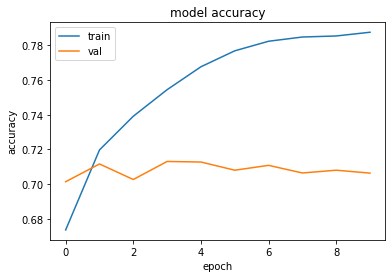

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

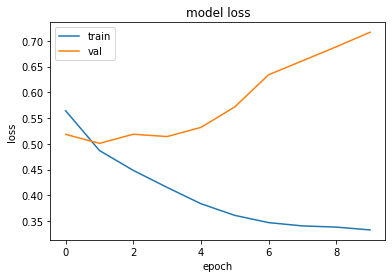

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
def convert_to_sequences(texts):
  sequences =  tokenizer.texts_to_sequences(texts)
  return pad_sequences(sequences, maxlen=maxlen)

In [ ]:
from keras.models import load_model
model = load_model(path + 'Test/weights_Textcnn_vreview_fastext_sentece.h5')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [ ]:
from sklearn import metrics
acc = model.predict(convert_to_sequences(test_v))
accr = np.round(acc)
print(metrics.f1_score(label_test, accr))

0.7504942416920326
